# Perdicting financial performance of movies before theatrical release

*"The challenge for candidates is to use the training data set to build a model to **predict the target variable 'Category' in column O of the training file.** The **prediction accuracy will be tested by applying the model to the scoring data set.** The actual values for the 'Category' target variable will be provided after submissions have been received. During the case interview, a higher emphasis will be placed on the thought process regarding the choice of the modeling approach rather than the raw 'out of sample' prediction accuracy."*

In [166]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
from pylab import rcParams
rcParams['figure.figsize'] = (6, 4)
import warnings
warnings.filterwarnings('ignore')

In [289]:
training = pd.read_excel('./training.xlsx')
scoring = pd.read_excel('./scoring.xlsx')
print training.isnull().values.any()
print scoring.isnull().values.any()

False
False


In [290]:
training['dataset'] = 'train'
scoring['dataset'] = 'test'
target = pd.DataFrame(training['Category'], columns=['Category'])
training.head(5)

,id,name,display_name,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name,total,Category,dataset
0,7950115,Avatar,Avatar,2009,0,Science Fiction,Original Screenplay,Animation/Live Action,Action,English,"For intense epic battle sequences and warfare,...",PG-13,Wide,2784,9,train
1,50950115,Harry Potter and the Deathly Hallows: Part II,Harry Potter and the Deathly Hallows: Part II,2011,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,for some sequences of intense action violence ...,PG-13,Wide,1328,9,train
2,119870115,Transformers 3,Transformers: Dark of the Moon,2011,1,Science Fiction,Based on TV,Animation/Live Action,Action,English,for intense prolonged sequences of sci-fi acti...,PG-13,Wide,1124,9,train
3,119590115,Toy Story 3,Toy Story 3,2010,1,Kids Fiction,Original Screenplay,Digital Animation,Adventure,English,General,G,Wide,1064,9,train
4,91700115,Pirates of the Caribbean 4,Pirates of the Caribbean: On Stranger Tides,2011,1,Fantasy,Based on Theme Park Ride,Live Action,Adventure,English,for intense sequences of action/adventure viol...,PG-13,Wide,1044,9,train


## 1. Exploratory Data Analysis 

### 1a. Exploring the categorical target labels

Since its a classificaiton problem, I want to visualize :

1. How skewed or imbalanced is the training dataset?
2. Distribution of the training data.
3. Selecting proper evaluation metrics.


Categorical Output Labels:  [1 2 3 4 5 6 7 8 9]


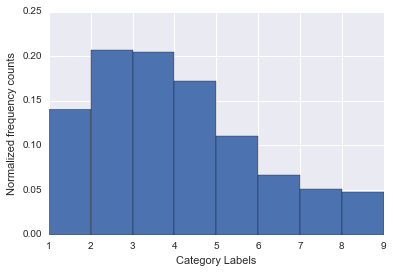

In [167]:
#target variable
bins = np.arange(1,10)
print 'Categorical Output Labels: ', np.unique(training.Category.values)
plt.hist(training.Category.values, normed=True, bins=bins)
plt.xlabel('Category Labels')
plt.ylabel('Normalized frequency counts')
plt.show()

There is **class imbalance!** 

These categorical output target values are ordered representations of discertized/binned box-office revenues. Take for example the extremes, **Category 1 represents a 'FLOP' movie** or one with lowest box-office revenues and the highest 
**Category 9 represents a 'BLOCKBUSTER'** or one with the highest box-office revenue. Other categories in the middle represent the similar associations with box-office revenues. 

**Insight:** It can be seen from the data that there are very low number of Blockbusters or high revenue generating movies and a relatively high (almost 50%) movies that generate low revenues. This makes a lot of intuitive sense.

**Insight:** There is **class imbalance** therefore need to use Stratified Sampling during cross validation.

### 1b. Analyze each feature

Find out features with high predictive power i.e features that are directly correlated with my target label Category. This is important for various reasons. 

* Firstly, I want to **drop redundant features** or features that won't help our classification model. 
* Helps in building **intuition** about our model and for **sanity checking**. 

Let's look at the features in small subsets and generate conditional plots.

In [162]:
print 'TRAINING FEATURES:'
print '\n'.join(training.columns)
#print '\nSCORING FEATURES:'
#print '\n'.join(scoring.columns)

TRAINING FEATURES:
id
name
display_name
production_year
movie_sequel
creative_type
source
production_method
genre
language
board_rating_reason
movie_board_rating_display_name
movie_release_pattern_display_name
total
Category
dataset


* Columns **id** is just an individual placeholder so it won't be useful for predicting the performance of the movie. We will **drop attribute id**
* Columns **name** and **display_name** are unqiue but correspond to a similar underlying quanity i.e release name of the movie. This isn't going to help us in predicting the category of a movie. **Drop attribute name**.
* Attribute **production_year will also be dropped since it doesn't hold much significance.** 

In [175]:
print 'Features 5-10'
training.ix[:,4:10].head(8)

Features 5-10


,movie_sequel,creative_type,source,production_method,genre,language
0,0,Science Fiction,Original Screenplay,Animation/Live Action,Action,English
1,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English
2,1,Science Fiction,Based on TV,Animation/Live Action,Action,English
3,1,Kids Fiction,Original Screenplay,Digital Animation,Adventure,English
4,1,Fantasy,Based on Theme Park Ride,Live Action,Adventure,English
5,0,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English
6,1,Super Hero,Based on Comic/Graphic Novel,Live Action,Action,English
7,1,Historical Fiction,Based on Theme Park Ride,Live Action,Adventure,English


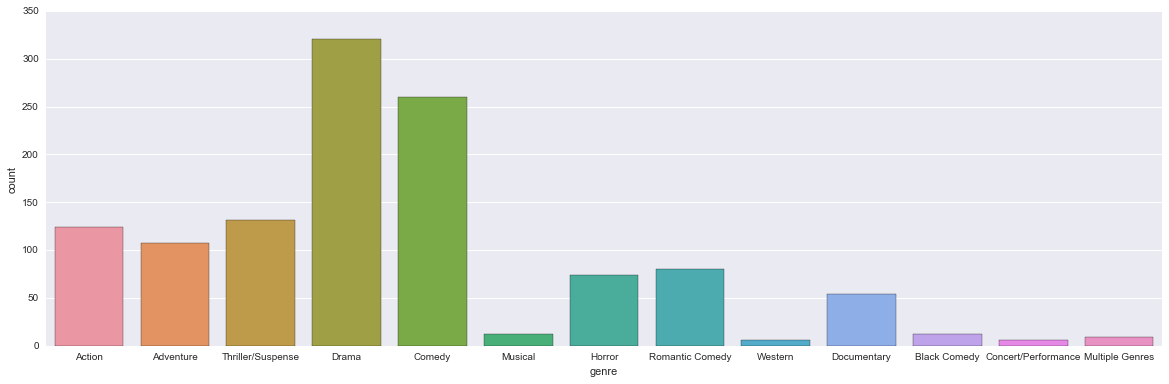

In [176]:
#grid = sns.FacetGrid(scoring, row='genre')
#grid = grid.map(plt.hist, "Category", bins=bins, normed=True)
rcParams['figure.figsize'] = (20, 6)
sns.countplot(training.genre)
plt.show()

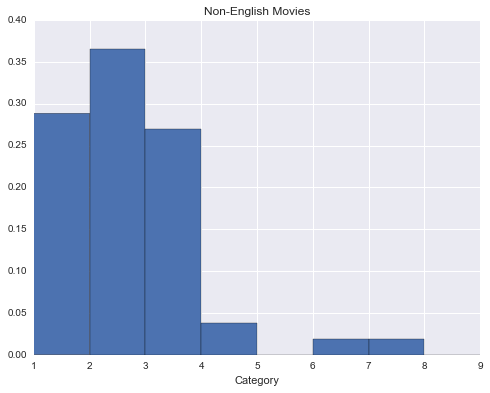

In [178]:
#print 'Category or Performance of Non-English Movies: '
rcParams['figure.figsize'] = (8, 6)
plt.hist(training[training.language != 'English']['Category'], normed=True, bins=bins)
plt.title('Non-English Movies')
plt.xlabel('Category')
plt.show()

Non-English movies don't perform as well commercially, around 65% movies are borderline Flops (Category <=3)! Infact there is **no Blockbuster or Category=9 non-English movie.** 

**Insight:** 
* Language is an important feature
* All attributes **creative_type, source, production_method, genre, Language** need to be LabelEncoded.

### 2b. Conditional Distributions to check correlations
By printing a number of these random combinations of attributes and Categories, I want to see how attribute *movie_board_rating_display_name* is related to the the target variable *Category*. For this I will use a Facegrid plot to generate conditional distributions.

All Rating categories: 
G
NC-17
Not Rated
PG
PG-13
R


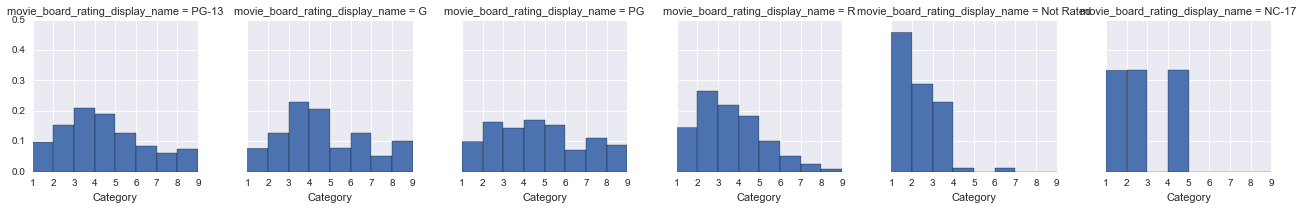

In [180]:
print 'All Rating categories: \n', 
print '\n'.join(np.unique(training.movie_board_rating_display_name.values))
bins = np.arange(1,10)
grid = sns.FacetGrid(training, col="movie_board_rating_display_name")
grid = grid.map(plt.hist, "Category", bins=bins, normed=True)

**Insight:** Movies that are **rated R or Not Rated perform much worse** (Category <= 3) than movies rated otherwise.

## 2 Preprocessing: Transforming Categorical Features

After having built some intuition and gained some insights about the dataset, I will now **convert categorical and string features to numerical data** that can be fed to the classification model.

### 2a. Common Features:

* It is necessary to combine the training and testing set before label encoding, since it is important to capture all labels within a categorical feature else we might get inconsistency errors.
* We **only retain features common to both training and testing files.** To building any generalization model, we assume that the training set is representative of any unseen data the model has to make predictions for.
* **Drop** column ***total*** in training set and column ***production_budget*** in scoring/testing set.

In [106]:

common_features = [
        'dataset',
        'movie_sequel',
        'creative_type',
        'source',
        'production_method',
        'genre',
        'language',
        'movie_board_rating_display_name',
        'movie_release_pattern_display_name',
        ]

categorical_features = [
                        'creative_type',
                        'source',
                        'movie_sequel',
                        'production_method',
                        'genre',
                        'language',
                        'movie_board_rating_display_name',
                        'movie_release_pattern_display_name'
                       ]

scoring = scoring[common_features]
training = training[common_features]

In [88]:
combined = pd.concat([training, scoring])
combined.head(3)

,dataset,movie_sequel,creative_type,source,production_method,genre,language,movie_board_rating_display_name,movie_release_pattern_display_name
0,train,0,Science Fiction,Original Screenplay,Animation/Live Action,Action,English,PG-13,Wide
1,train,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,PG-13,Wide
2,train,1,Science Fiction,Based on TV,Animation/Live Action,Action,English,PG-13,Wide


In [ ]:
combined['language'] = combined['language'].apply(lambda value: map_language(value))
sns.countplot(y=combined.language)

In [89]:
source_data = combined['dataset']
categorical_data = combined[categorical_features]
categorical_data.head()
#print np.unique(categorical_data.source.values)

,creative_type,source,movie_sequel,production_method,genre,language,movie_board_rating_display_name,movie_release_pattern_display_name
0,Science Fiction,Original Screenplay,0,Animation/Live Action,Action,English,PG-13,Wide
1,Fantasy,Based on Fiction Book/Short Story,1,Animation/Live Action,Adventure,English,PG-13,Wide
2,Science Fiction,Based on TV,1,Animation/Live Action,Action,English,PG-13,Wide
3,Kids Fiction,Original Screenplay,1,Digital Animation,Adventure,English,G,Wide
4,Fantasy,Based on Theme Park Ride,1,Live Action,Adventure,English,PG-13,Wide


### 2b. Label Encoding:

In [90]:
from sklearn.preprocessing import LabelEncoder
labelencoded_data = categorical_data.apply(LabelEncoder().fit_transform)
labelencoded_data.head()

,creative_type,source,movie_sequel,production_method,genre,language,movie_board_rating_display_name,movie_release_pattern_display_name
0,7,13,0,0,0,2,4,6
1,3,2,1,0,1,2,4,6
2,7,9,1,0,0,2,4,6
3,5,13,1,1,1,2,0,6
4,3,10,1,3,1,2,4,6


### 3b. One Hot Encoding: 

To further remove any relationships introduced by label encoding within a class, I will binarize each category label.

In [193]:
onehot_data = pd.get_dummies(categorical_data)
print onehot_data.shape
onehot_data.head()

(1287, 75)


,movie_sequel,creative_type_Contemporary Fiction,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Multiple Creative Types,creative_type_Science Fiction,creative_type_Super Hero,...,movie_board_rating_display_name_PG,movie_board_rating_display_name_PG-13,movie_board_rating_display_name_R,movie_release_pattern_display_name_Exclusive,movie_release_pattern_display_name_Expands Wide,movie_release_pattern_display_name_IMAX,movie_release_pattern_display_name_Limited,movie_release_pattern_display_name_Oscar Qualifying Run,movie_release_pattern_display_name_Special Engagement,movie_release_pattern_display_name_Wide
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [194]:
data = pd.concat([onehot_data, source_data], axis=1)
data.head()

,movie_sequel,creative_type_Contemporary Fiction,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Multiple Creative Types,creative_type_Science Fiction,creative_type_Super Hero,...,movie_board_rating_display_name_PG-13,movie_board_rating_display_name_R,movie_release_pattern_display_name_Exclusive,movie_release_pattern_display_name_Expands Wide,movie_release_pattern_display_name_IMAX,movie_release_pattern_display_name_Limited,movie_release_pattern_display_name_Oscar Qualifying Run,movie_release_pattern_display_name_Special Engagement,movie_release_pattern_display_name_Wide,dataset
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,train
1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,train
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,train
3,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,train
4,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,train


#### Splitting the training and testing (scoring) sets 

In [196]:
train = data[data['dataset'] == 'train']
del train['dataset']
test = data[data['dataset'] == 'test']
del test['dataset']

In [197]:
print 'training shape', train.shape
train.head(3)

training shape (1196, 75)


,movie_sequel,creative_type_Contemporary Fiction,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Multiple Creative Types,creative_type_Science Fiction,creative_type_Super Hero,...,movie_board_rating_display_name_PG,movie_board_rating_display_name_PG-13,movie_board_rating_display_name_R,movie_release_pattern_display_name_Exclusive,movie_release_pattern_display_name_Expands Wide,movie_release_pattern_display_name_IMAX,movie_release_pattern_display_name_Limited,movie_release_pattern_display_name_Oscar Qualifying Run,movie_release_pattern_display_name_Special Engagement,movie_release_pattern_display_name_Wide
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [198]:
print 'testing shape', test.shape
test.head(3)

testing shape (91, 75)


,movie_sequel,creative_type_Contemporary Fiction,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Multiple Creative Types,creative_type_Science Fiction,creative_type_Super Hero,...,movie_board_rating_display_name_PG,movie_board_rating_display_name_PG-13,movie_board_rating_display_name_R,movie_release_pattern_display_name_Exclusive,movie_release_pattern_display_name_Expands Wide,movie_release_pattern_display_name_IMAX,movie_release_pattern_display_name_Limited,movie_release_pattern_display_name_Oscar Qualifying Run,movie_release_pattern_display_name_Special Engagement,movie_release_pattern_display_name_Wide
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 4. Train and Validation Splitting: Stratififed splits

Stratified splitting to preserve class proportion.

In [259]:
from sklearn.cross_validation import StratifiedKFold
from __future__ import division

kf = StratifiedKFold(target.Category, n_folds=10)

train_index, cv_index = next(iter(kf))

#Training Set
X_train, y_train = train.iloc[train_index], target.iloc[train_index]
#Validation Set
X_cv, y_cv = train.iloc[cv_index], target.iloc[cv_index]

print (X_train.shape), X_cv.shape
X_cv.head()

(1073, 75) (123, 75)


,movie_sequel,creative_type_Contemporary Fiction,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Multiple Creative Types,creative_type_Science Fiction,creative_type_Super Hero,...,movie_board_rating_display_name_PG,movie_board_rating_display_name_PG-13,movie_board_rating_display_name_R,movie_release_pattern_display_name_Exclusive,movie_release_pattern_display_name_Expands Wide,movie_release_pattern_display_name_IMAX,movie_release_pattern_display_name_Limited,movie_release_pattern_display_name_Oscar Qualifying Run,movie_release_pattern_display_name_Special Engagement,movie_release_pattern_display_name_Wide
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Proportion in each class


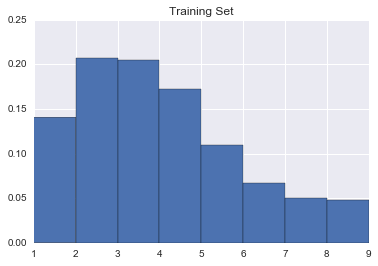

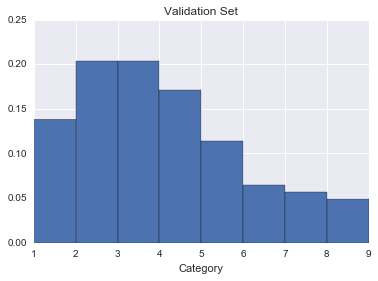

In [203]:
rcParams['figure.figsize'] = (6, 4)
print 'Proportion in each class'
plt.title('Training Set')
plt.hist(y_train.values,bins=np.arange(1,10), normed=True)
plt.show()
plt.title('Validation Set')
plt.hist(y_cv.values, bins=np.arange(1,10), normed=True)
plt.xlabel('Category')
plt.show()

In [252]:
train.head()

,movie_sequel,creative_type_Contemporary Fiction,creative_type_Dramatization,creative_type_Factual,creative_type_Fantasy,creative_type_Historical Fiction,creative_type_Kids Fiction,creative_type_Multiple Creative Types,creative_type_Science Fiction,creative_type_Super Hero,...,movie_board_rating_display_name_PG,movie_board_rating_display_name_PG-13,movie_board_rating_display_name_R,movie_release_pattern_display_name_Exclusive,movie_release_pattern_display_name_Expands Wide,movie_release_pattern_display_name_IMAX,movie_release_pattern_display_name_Limited,movie_release_pattern_display_name_Oscar Qualifying Run,movie_release_pattern_display_name_Special Engagement,movie_release_pattern_display_name_Wide
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 5. Model Building


### 5a. Validation Metric
Since this is a multi-classification problem with skewed datasets I will be using the **precision with micro averaging** for during cross-validation.

In [207]:
from sklearn.metrics import make_scorer, precision_score, f1_score

pre_scorer = make_scorer(score_func=precision_score,
    greater_is_better=True,
    average='micro')

data = X_train.values
crossval = X_cv.values

### 5b. Baseline: Majority Prediction

In [229]:
from sklearn.dummy import DummyClassifier
majority_classifier = DummyClassifier(strategy="most_frequent").fit(data, y_train.Category.values)

print 'Majority Baseline: ', precision_score(y_cv.values, majority_classifier.predict(crossval), average='micro')


Majority Baseline:  0.20325203252


### 5c. Cross Validation and Spot Checking Algorithms

I'll quickly try training and validation a variety of classification algorithms that make some different assumptions about the input-space. Namely:

* Tree-based (Boosted Trees, CART, Random Forests) 
* Parameteric (Logistic Regression)
* Non-parametric (K-Nearest Neighbours)
* Probabilistic (Naive Bayes, Multinomial Bayes) 
* Non-linear (Support Vector Machines).

In [222]:
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier #ensembles
from sklearn.svm import SVC #Support Vectors
from sklearn.linear_model import LogisticRegression #Linear 
from sklearn.neighbors import KNeighborsClassifier #Non-parametric
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')

In [240]:

classifiers = {'Random Forest': RandomForestClassifier(n_estimators=500, criterion='gini', oob_score=True), 
               'XGBoost': XGBClassifier(n_estimators=500),
               'ExtraTrees':ExtraTreesClassifier(n_estimators=150),
               'Support Vector': SVC(C=100, kernel='rbf'),
               'Logistic Regression with L1': LogisticRegression(penalty='l2', C=0.1), 
               'CART ': DecisionTreeClassifier(), 
               'K-Nearest Neighbours':KNeighborsClassifier(n_neighbors=4, metric='hamming'),
               'naive bayes': GaussianNB(),
               'Multinomial bayes': MultinomialNB()              
              }

train_models = {}
skf = StratifiedKFold(target.Category.values, n_folds=10, shuffle=True)

for name, clf in classifiers.iteritems():
    f1 = cross_val_score(clf, train.values, y=target.Category.values, cv=skf, scoring=pre_scorer)
    print "\n%s: %f +/- %f" % (name, np.mean(f1), np.std(f1))


CART : 0.271035 +/- 0.034334

ExtraTrees: 0.265943 +/- 0.032648

Multinomial bayes: 0.250111 +/- 0.024927

K-Nearest Neighbours: 0.233266 +/- 0.041017

Logistic Regression with L1: 0.260219 +/- 0.025243

Support Vector: 0.293545 +/- 0.023133

XGBoost: 0.266296 +/- 0.039199

naive bayes: 0.091206 +/- 0.015908

Random Forest: 0.266744 +/- 0.029439


* All algorithms except Naive Bayes beat the precision score of the majority classifier.
* Comparable precision scores for most of the algorithm.
* **Highest score:** Support Vector Machines, Random Forests, XGBoost
* **Lowest Score:** Naive Bayes

In [255]:
for name, clf in classifiers.iteritems():
    clf.fit(data, y_train.values)
    train_models[name] = clf.predict(crossval)

df_pred = pd.DataFrame(train_models)
df_pred['Real_Label'] = y_cv.Category.values

In [256]:
df_pred[df_pred['Real_Label'] == 5].corr()

,CART,ExtraTrees,K-Nearest Neighbours,Logistic Regression with L1,Multinomial bayes,Random Forest,Support Vector,XGBoost,naive bayes,Real_Label
CART,1.000000,0.613152,0.261252,0.696597,0.761063,0.165993,0.585827,0.251398,0.524654,NaN
ExtraTrees,0.613152,1.000000,-0.262834,0.578282,0.773304,0.715348,0.964268,0.683535,-0.026709,NaN
K-Nearest Neighbours,0.261252,-0.262834,1.000000,0.280856,-0.113101,-0.128274,-0.331986,-0.345372,0.326020,NaN
Logistic Regression with L1,0.696597,0.578282,0.280856,1.000000,0.724861,0.307385,0.592758,0.366931,0.354292,NaN
Multinomial bayes,0.761063,0.773304,-0.113101,0.724861,1.000000,0.345139,0.859335,0.467251,0.432196,NaN
Random Forest,0.165993,0.715348,-0.128274,0.307385,0.345139,1.000000,0.699487,0.789344,-0.355201,NaN
Support Vector,0.585827,0.964268,-0.331986,0.592758,0.859335,0.699487,1.000000,0.748105,0.000000,NaN
XGBoost,0.251398,0.683535,-0.345372,0.366931,0.467251,0.789344,0.748105,1.000000,-0.435677,NaN
naive bayes,0.524654,-0.026709,0.326020,0.354292,0.432196,-0.355201,0.000000,-0.435677,1.000000,NaN
Real_Label,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [304]:
## Tuning hyperparameters of SVM
est = GridSearchCV(svm, param_grid)

param_grid = {'class_weight': ['balanced', 'auto'],
              'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              }

svm = SVC()

skf = StratifiedKFold(y_train.Category.values)
grid = GridSearchCV(svm, param_grid, cv=skf, verbose=2, scoring=pre_scorer)
grid.fit(X_train.values, y_train.Category.values)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] kernel=rbf, C=0.001, class_weight=balanced ......................
[CV] ............. kernel=rbf, C=0.001, class_weight=balanced -   0.3s
[CV] kernel=rbf, C=0.001, class_weight=balanced ......................
[CV] ............. kernel=rbf, C=0.001, class_weight=balanced -   0.2s
[CV] kernel=rbf, C=0.001, class_weight=balanced ......................
[CV] ............. kernel=rbf, C=0.001, class_weight=balanced -   0.2s
[CV] kernel=linear, C=0.001, class_weight=balanced ...................
[CV] .......... kernel=linear, C=0.001, class_weight=balanced -   0.1s
[CV] kernel=linear, C=0.001, class_weight=balanced ...................
[CV] .......... kernel=linear, C=0.001, class_weight=balanced -   0.1s
[CV] kernel=linear, C=0.001, class_weight=balanced ...................
[CV] .......... kernel=linear, C=0.001, class_weight=balanced -   0.1s
[CV] kernel=rbf, C=0.001, class_weight=auto ..........................
[CV] ...........

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   21.8s finished


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[9 9 ..., 1 1], n_folds=3, shuffle=False, random_state=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf', 'linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', 'auto']},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(precision_score, average=micro), verbose=2)

### Ensembles: 
1. A lower correlation between ensemble model members seems to result in an increase in the error-correcting capability.

2. **Majority votes make most sense** when the evaluation metric requires hard predictions, for instance with **(multiclass-) classification accuracy**.

In [329]:
from sklearn.ensemble.voting_classifier import VotingClassifier

rf = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=25, 
                                                       min_samples_leaf=1)
svm = SVC(C=100, kernel='rbf')
knn = KNeighborsClassifier(n_neighbors=4)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1)

skf = StratifiedKFold(target.Category.values, n_folds=10)
voter = VotingClassifier(estimators=[('svm', svm), ('xgb', xgb), ('knn', knn)], weights=[2,1,1])
voter.fit(X_train.values, y_train.Category.values)
print 'Validation accuracy: ', accuracy_score(y_cv.Category.values, voter.predict(X_cv.values))

Validation accuracy:  0.349593495935


In [286]:
#Pickle the voting model
import cPickle as pickle
with open('majority_ensemble','w') as fp:
    pickle.dump(voter, fp)

In [297]:
voter.fit(train.values, target.values)
scoring['prediction_ensemble'] = voter.predict(test.values)
scoring.to_excel('submission_siddharth.xlsx')
scoring.head(10)

,id,name,display_name,production_budget,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name,dataset,prediction_ensemble
0,7970115,"Avengers, The (2011)",Marvel's The Avengers,225000000,2012,0,Super Hero,Based on Comic/Graphic Novel,Live Action,Adventure,English,for intense sequences of sci-fi violence and a...,PG-13,Wide,test,6
1,174540115,Dark Knight Rises The,The Dark Knight Rises,0,2012,1,Super Hero,Based on Comic/Graphic Novel,Live Action,Action,English,"for intense sequences of violence and action, ...",PG-13,Wide,test,9
2,149080115,Bond 23,Skyfall,200000000,2012,1,Contemporary Fiction,Based on Fiction Book/Short Story,Live Action,Action,English,"for intense violent sequences throughout, some...",PG-13,Wide,test,5
3,136020115,Twilight Saga Breaking Dawn Part 2 The,"The Twilight Saga: Breaking Dawn, Part 2",136200000,2012,1,Fantasy,Based on Fiction Book/Short Story,Live Action,Drama,English,for sequences of violence including disturbing...,PG-13,Wide,test,8
4,53500115,"Hobbit, The",The Hobbit: An Unexpected Journey,270000000,2012,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,for extended sequences of intense fantasy acti...,PG-13,Wide,test,9
5,109880115,Spider-Man 4,The Amazing Spider-Man,220000000,2012,1,Super Hero,Based on Comic/Graphic Novel,Live Action,Adventure,English,for sequences of action and violence.,PG-13,Wide,test,9
6,168300115,Brave,Brave,0,2012,0,Kids Fiction,Original Screenplay,Digital Animation,Adventure,English,for some scary action and rude humor.,PG,Wide,test,8
7,72600115,Madagascar 3,Madagascar 3: Europe's Most Wanted,0,2012,1,Kids Fiction,Original Screenplay,Digital Animation,Adventure,English,for some mild action and rude humor.,PG,Wide,test,8
8,154940115,Reboot Ralph,Wreck-It Ralph,165000000,2012,0,Kids Fiction,Original Screenplay,Digital Animation,Adventure,English,for some rude humor and mild action/violence.,PG,Wide,test,8
9,149170115,Ice Age Continental Drift,Ice Age: Continental Drift,0,2012,1,Fantasy,Original Screenplay,Digital Animation,Adventure,English,for mild rude humor and action/peril.,PG,Wide,test,9


In [334]:
scoring['prediction_ensemble'].to_csv('results.csv')

## Conclusion

We gained some insights about the data initially in the Exploratory analysis phase, I want to just quickly check if those sanity checks apply in our predictions or not. Namely the **sequel, genre and language** of the movies have a significant impact over the performance. While there is no possible way to achieve to verify the accuracy of the classifier without test labels, I still want to check for the **right and left skews of conditional distributions** values.

### Performance distribution of movies given genre: 

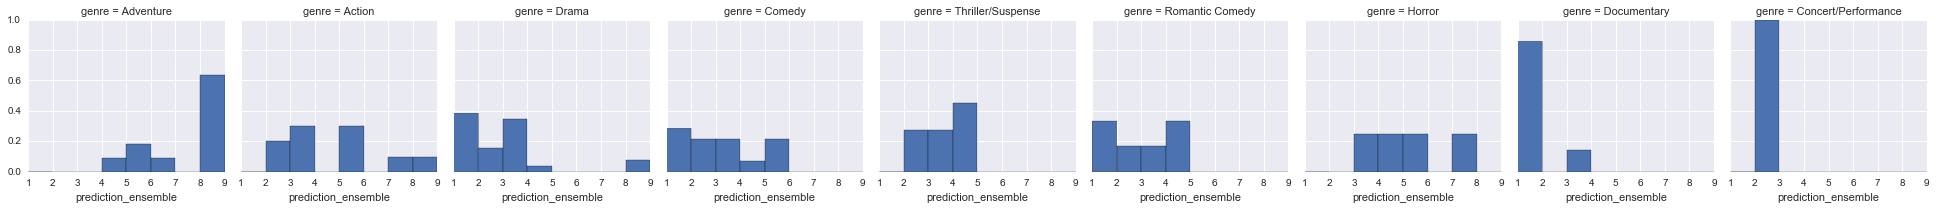

In [312]:
bins = np.arange(1,10)
grid = sns.FacetGrid(scoring, col='genre')
grid = grid.map(plt.hist, "prediction_ensemble", bins=bins, normed=True)
plt.show()

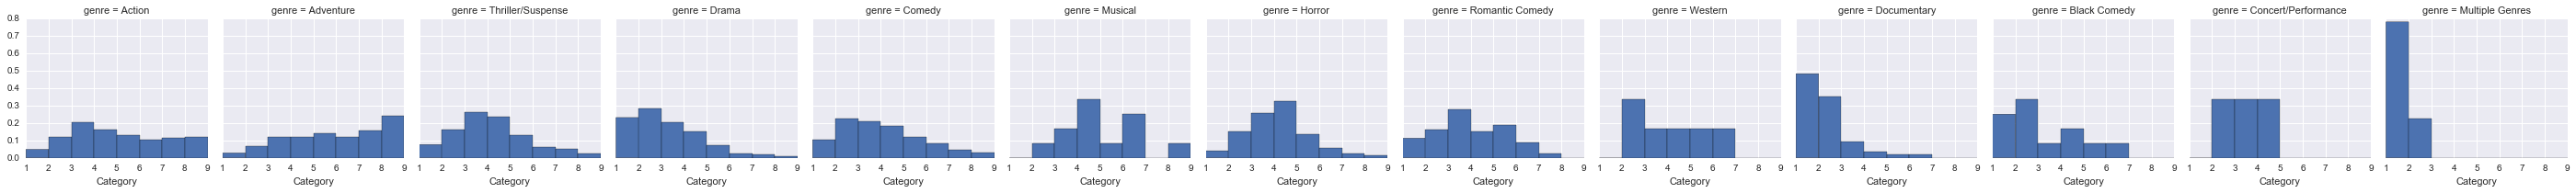

In [126]:
bins = np.arange(1,10)
grid = sns.FacetGrid(training, col='genre')
grid = grid.map(plt.hist, "Category", bins=bins, normed=True)
plt.show()

While the distributions haven't been exactly mimicked the skewness of the categorical distributions are still intact.

### Performance distribution of English Movies

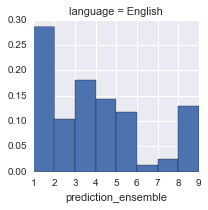

In [315]:
bins = np.arange(1,10)
grid = sns.FacetGrid(scoring[scoring['language'] == 'English'], col='language')
grid = grid.map(plt.hist, "prediction_ensemble", bins=bins, normed=True)
plt.show()

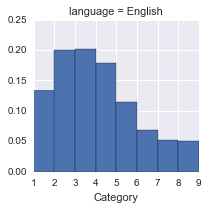

In [317]:
bins = np.arange(1,10)
grid = sns.FacetGrid(training[training['language'] == 'English'], col='language')
grid = grid.map(plt.hist, "Category", bins=bins, normed=True)
plt.show()

### Performance distribution of non-English movies

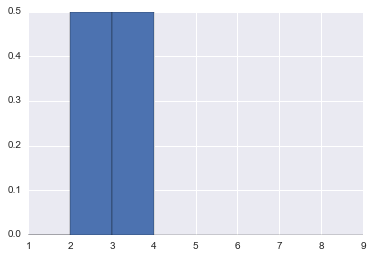

In [325]:
bins = np.arange(1,10)
plt.hist(scoring[scoring['language'] != 'English']['prediction_ensemble'], bins=bins, normed=True)
plt.show()

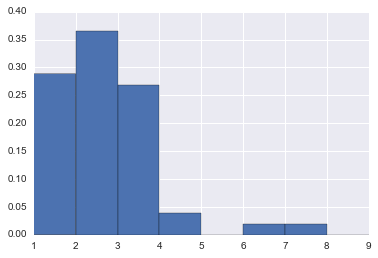

In [326]:
bins = np.arange(1,10)
plt.hist(training[training['language'] != 'English']['Category'], bins=bins, normed=True)
plt.show()

This can also be better with more training instances, but the skewness of the data is preserved (left skewed) and the initial hypothesis *non-English movies generally don't perform too well* is supported by the predictions of the model.